# Setup Inicial

In [1]:
#Python Default 

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

import pickle
import time
import random
import os
import inspect
import pathlib

#Essentials

import IPython
import numpy as np
from bs4 import BeautifulSoup
import requests
import func_timeout
import pandas as pd
from itables import show
from scipy.optimize import curve_fit

#from objproxies import *

import matplotlib.pyplot as plt

#Qiskit

from qiskit.circuit import Gate
from qiskit.circuit.library import *
from qiskit import transpile
from qiskit.providers.models import *
from qiskit_ibm_runtime.fake_provider import *
from qiskit.providers.fake_provider import *
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit_aer import StatevectorSimulator
import qiskit_aer

## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.problems import EigenstateResult

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF


## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import VQE as  VQE_algorithms   #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Estimators

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

from qiskit_ibm_runtime import Estimator 

from qiskit_ibm_runtime import EstimatorV2

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options

## Braket

from braket.tracking import Tracker
from qiskit_braket_provider import *


%matplotlib widget
#%matplotlib inline

In [2]:
# Backends

provider = BraketProvider()
local_simulator = BraketLocalBackend()
sv1 = provider.get_backend("SV1")
aria = provider.get_backend("Aria 1")
harmony = provider.get_backend("Harmony")
statevector_simulator = StatevectorSimulator()

# Setup inicial do problema

driver = PySCFDriver(
    atom= f"H 0 0 0; H 0 0 1",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

#estimator = Estimator(backend = local_simulator, options={"shots" : 2000, "noise_model" : noise_model, "coupling_map" : coupling_map})

estimator = Estimator(backend = local_simulator)

mapper = JordanWignerMapper()

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE_algorithms(estimator, ansatz, COBYLA())

vqe_solver.initial_point = [0.0] * ansatz.num_parameters

calc = GroundStateEigensolver(mapper, vqe_solver)

minimum_eigenvalue = vqe_solver.compute_minimum_eigenvalue(calc.get_qubit_operators(es_problem)[0])

# Criando Circuito Aria - AWS

circuito = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), aria)

# Criando Circuito Brisbane - IBM

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

circuito_ibm = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), backend)

hamiltoniano = es_problem.second_q_ops()[0]

num_qubits_hamiltonian = JordanWignerMapper().map(hamiltoniano).num_qubits

new_circuit = QuantumCircuit(num_qubits_hamiltonian)

for gate in circuito_ibm.data:

    if all(circuito_ibm.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
        new_circuit.append(gate[0], [circuito_ibm.qubits.index(qubit) for qubit in gate[1]])

circuito_ibm = new_circuit

# Funções Globais

In [3]:
def get_current_directory():
    try:
        
        directory = os.path.dirname(os.path.abspath(__file__))

    except:
        
        ip = IPython.get_ipython()
        directory = None
        if '__vsc_ipynb_file__' in ip.user_ns:
            directory = os.path.dirname(ip.user_ns['__vsc_ipynb_file__'])
        
    return directory 


def salvar(a):
    
    script_dir = get_current_directory()
    
    dados_dir = os.path.join(script_dir, 'dados')
    
    os.makedirs(dados_dir, exist_ok=True)
    
    file_path = os.path.join(dados_dir, f'{a}.pickle')
    
    with open(file_path, 'wb') as f:
        pickle.dump(eval(a), f)

def abrir(a):
    
    script_dir = get_current_directory()
    
    file_path = os.path.join(script_dir, 'dados', f'{a}.pickle')
    
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [4]:

def run_statevector(circuit, driver, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   estado = Statevector.from_instruction(circuit)
   
   expectation_value = estado.expectation_value(mapper.map(hamiltoniano))
   
   return expectation_value.real

def run_estimator(circuit, driver, backend = None, shots = 2000, noise_model = None, coupling_map = None, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   if noise_model is not None:
      
      estimator = Estimator(backend = backend, options = {"shots" : shots, "noise_model" : noise_model, "coupling_map" : coupling_map})
   
   else :
      
      estimator = Estimator(backend = backend, options = {"shots" : shots})
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit

   if shots != None:
   
      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)   
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, skip_transpilation = skip_transpilation)
   
   else :

      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, approximation = True, skip_transpilation = skip_transpilation)
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, approximation = True, skip_transpilation = skip_transpilation)
      
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer_noise(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True, noise_model = None, coupling_map = None):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   estimator = Estimator_Aer(backend_options={'noise_model': noise_model}, run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)         
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

ESTIMATORS = {
    'statevector': run_statevector,
    'estimator': run_estimator,
    'estimator_aer': run_estimator_aer,
    'estimator_aer_noise': run_estimator_aer_noise,
}

def check(original_value, target, driver, difference_percentage, estimator_name='statevector', **kwargs):
    estimator_function = ESTIMATORS[estimator_name]
    target_value = estimator_function(target, driver, **kwargs)
    return abs(original_value - target_value) < difference_percentage * abs(original_value), target_value

# Importando Dados

In [5]:
def abrir_modelo(a):
    
    exec(f'modelo{a}_brisbane_3030_aer_2500 = abrir("modelo{a}_brisbane_3030_aer_2500")')
    exec(f'modelo{a}_brisbane_3030_simulator_2500 = abrir("modelo{a}_brisbane_3030_simulator_2500")')
    
    return eval(f'modelo{a}_brisbane_3030_aer_2500'), eval(f'modelo{a}_brisbane_3030_simulator_2500')

## Modelo 1

In [6]:
modelo = 1

aer, simulator = abrir_modelo(modelo)

In [7]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)) + ' (original)',
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(aer):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := simulator[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_temp = pd.DataFrame(data)

show(df_temp)

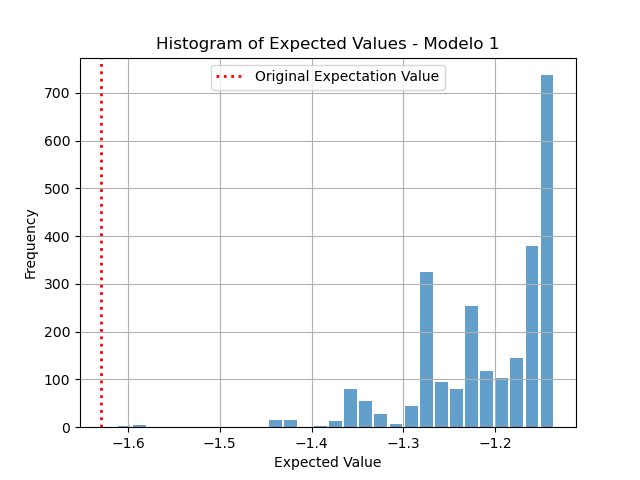

In [8]:
expected_values = df_temp['expectation_value_exact']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of Expected Values - Modelo {modelo}')
plt.legend()
plt.grid(True)

plt.show()

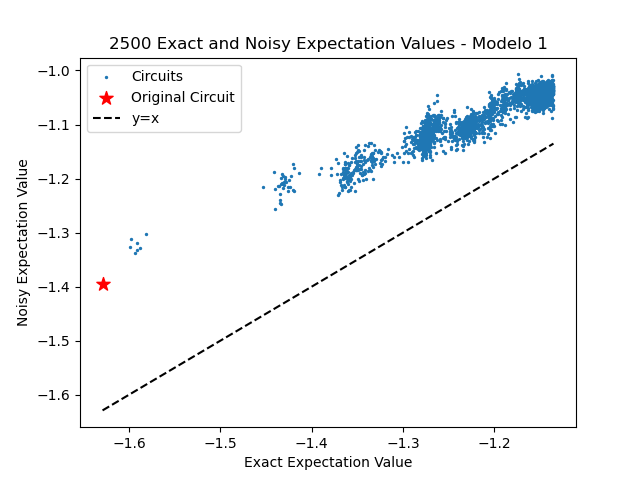

In [9]:
plt.figure()
plt.scatter(df_temp['expectation_value_exact'][1:], df_temp['expectation_value_noisy'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_exact'], df_temp.loc[0, 'expectation_value_noisy'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot([min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], [min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], 'k--', label='y=x')
plt.xlabel('Exact Expectation Value')
plt.ylabel('Noisy Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

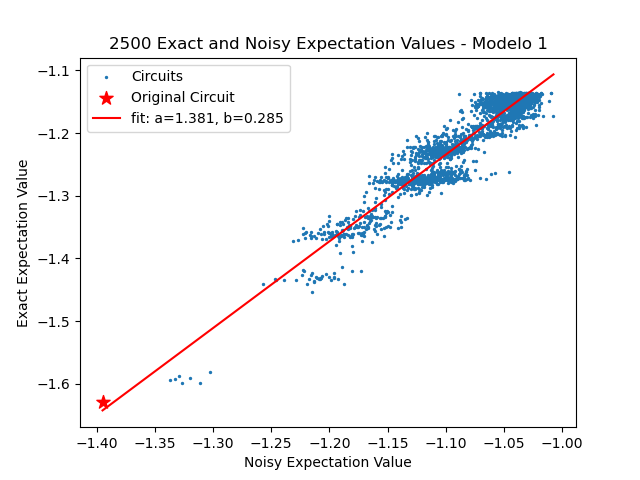

In [10]:
popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:])

plt.figure()
plt.scatter(df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_noisy'], df_temp.loc[0, 'expectation_value_exact'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot((x := np.linspace(min(df_temp['expectation_value_noisy']), max(df_temp['expectation_value_noisy']), 100)), func(x, *popt), "r", label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Noisy Expectation Value')
plt.ylabel('Exact Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

In [11]:
original = df_temp.loc[0, 'expectation_value_exact']
noisy = df_temp.loc[0, 'expectation_value_noisy']
corrected = func(noisy, *popt)
percentage = abs(abs(corrected - original) / original)* 100
percentage_noisy = abs(abs(corrected - noisy) / noisy)* 100

print(f"\nModelo {modelo} : \n\nOriginal Expectation Value: {original}\nNoisy Expectation Value: {noisy}\nCorrected Expectation Value: {corrected}\nPercentage Difference: {percentage}%\nPercentage Noisy Difference: {percentage_noisy}%")


Modelo 1 : 

Original Expectation Value: -1.6289938092430294
Noisy Expectation Value: -1.3950818279804187
Corrected Expectation Value: -1.6422348571020946
Percentage Difference: 0.8128359840248959%
Percentage Noisy Difference: 17.71602383205474%


## Modelo 2

In [12]:
modelo = 2

aer, simulator = abrir_modelo(modelo)

In [13]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)) + ' (original)',
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(aer):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := simulator[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_temp = pd.DataFrame(data)

show(df_temp)

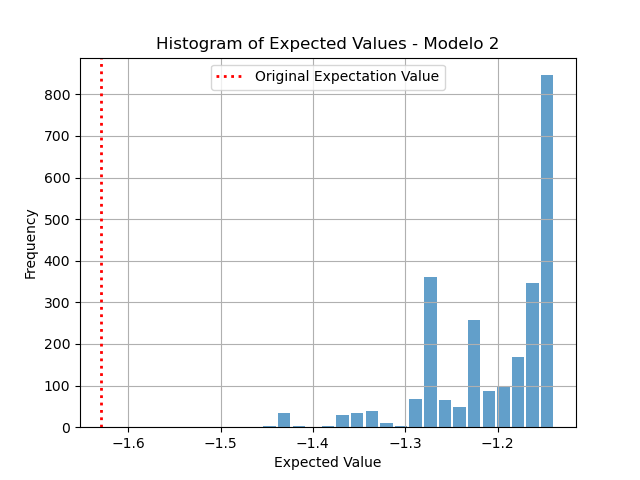

In [14]:
expected_values = df_temp['expectation_value_exact']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of Expected Values - Modelo {modelo}')
plt.legend()
plt.grid(True)

plt.show()

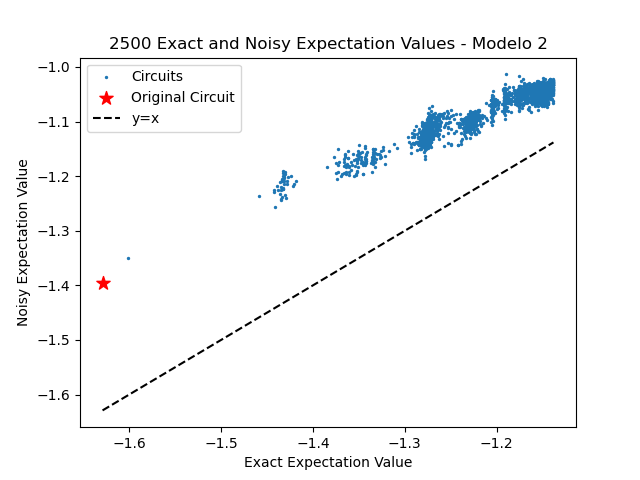

In [15]:
plt.figure()
plt.scatter(df_temp['expectation_value_exact'][1:], df_temp['expectation_value_noisy'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_exact'], df_temp.loc[0, 'expectation_value_noisy'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot([min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], [min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], 'k--', label='y=x')
plt.xlabel('Exact Expectation Value')
plt.ylabel('Noisy Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

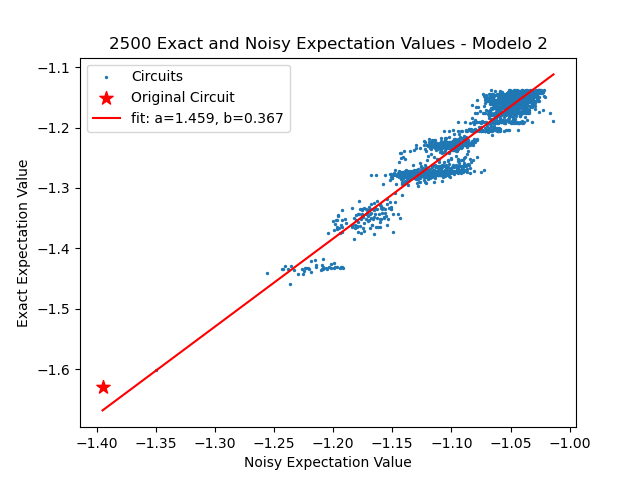

In [16]:
popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:])

plt.figure()
plt.scatter(df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_noisy'], df_temp.loc[0, 'expectation_value_exact'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot((x := np.linspace(min(df_temp['expectation_value_noisy']), max(df_temp['expectation_value_noisy']), 100)), func(x, *popt), "r", label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Noisy Expectation Value')
plt.ylabel('Exact Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

In [17]:
original = df_temp.loc[0, 'expectation_value_exact']
noisy = df_temp.loc[0, 'expectation_value_noisy']
corrected = func(noisy, *popt)
percentage = abs(abs(corrected - original) / original)* 100
percentage_noisy = abs(abs(corrected - noisy) / noisy)* 100

print(f"\nModelo {modelo} : \n\nOriginal Expectation Value: {original}\nNoisy Expectation Value: {noisy}\nCorrected Expectation Value: {corrected}\nPercentage Difference: {percentage}%\nPercentage Noisy Difference: {percentage_noisy}%")


Modelo 2 : 

Original Expectation Value: -1.6289938092430294
Noisy Expectation Value: -1.3950818279804187
Corrected Expectation Value: -1.668519041639703
Percentage Difference: 2.426358662163396%
Percentage Noisy Difference: 19.600084251339155%


## Modelo 3

In [18]:
modelo = 3

aer, simulator = abrir_modelo(modelo)

In [19]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)) + ' (original)',
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(aer):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := simulator[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_temp = pd.DataFrame(data)

show(df_temp)

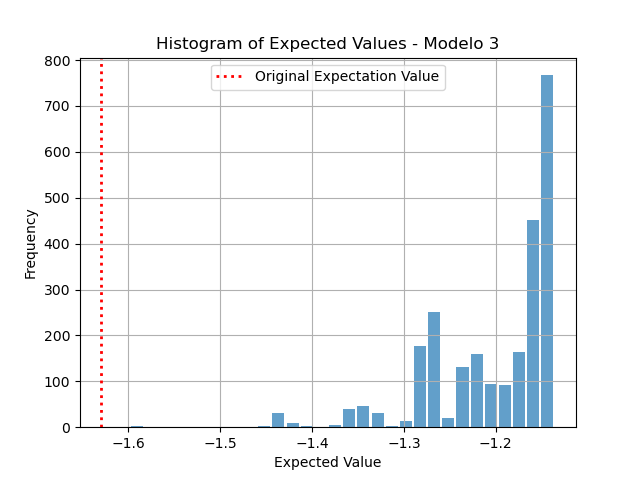

In [20]:
expected_values = df_temp['expectation_value_exact']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of Expected Values - Modelo {modelo}')
plt.legend()
plt.grid(True)

plt.show()

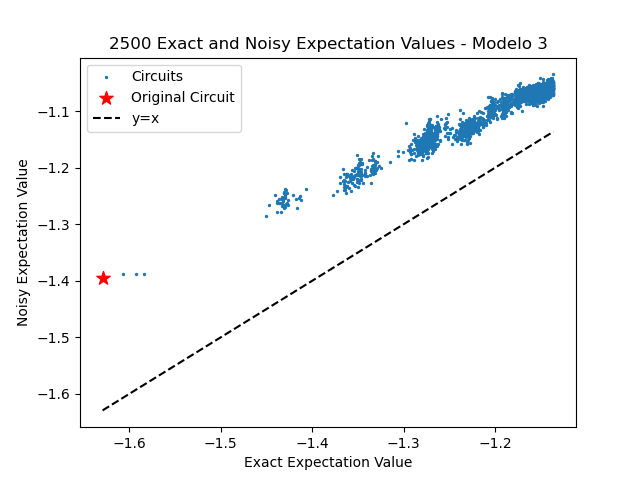

In [21]:
plt.figure()
plt.scatter(df_temp['expectation_value_exact'][1:], df_temp['expectation_value_noisy'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_exact'], df_temp.loc[0, 'expectation_value_noisy'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot([min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], [min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], 'k--', label='y=x')
plt.xlabel('Exact Expectation Value')
plt.ylabel('Noisy Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

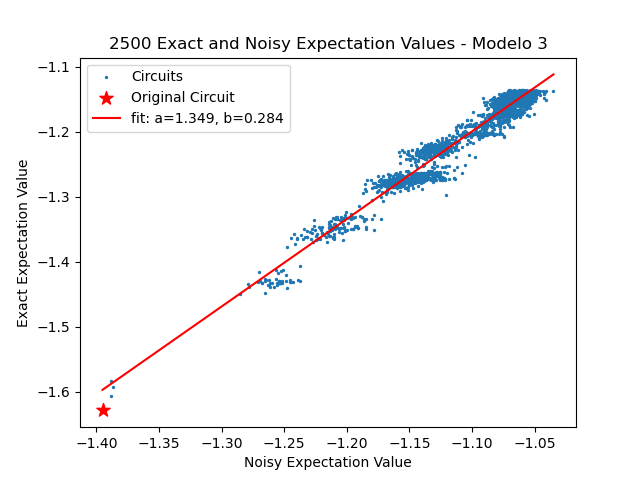

In [22]:
popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:])

plt.figure()
plt.scatter(df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_noisy'], df_temp.loc[0, 'expectation_value_exact'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot((x := np.linspace(min(df_temp['expectation_value_noisy']), max(df_temp['expectation_value_noisy']), 100)), func(x, *popt), "r", label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Noisy Expectation Value')
plt.ylabel('Exact Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

In [23]:
original = df_temp.loc[0, 'expectation_value_exact']
noisy = df_temp.loc[0, 'expectation_value_noisy']
corrected = func(noisy, *popt)
percentage = abs(abs(corrected - original) / original)* 100
percentage_noisy = abs(abs(corrected - noisy) / noisy)* 100

print(f"\nModelo {modelo} : \n\nOriginal Expectation Value: {original}\nNoisy Expectation Value: {noisy}\nCorrected Expectation Value: {corrected}\nPercentage Difference: {percentage}%\nPercentage Noisy Difference: {percentage_noisy}%")


Modelo 3 : 

Original Expectation Value: -1.6289938092430294
Noisy Expectation Value: -1.3950818279804187
Corrected Expectation Value: -1.5972764989726125
Percentage Difference: 1.9470491594535586%
Percentage Noisy Difference: 14.493391494096059%


## Modelo 4

In [24]:
modelo = 4

aer, simulator = abrir_modelo(modelo)

In [25]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)) + ' (original)',
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(aer):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := simulator[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_temp = pd.DataFrame(data)

show(df_temp)

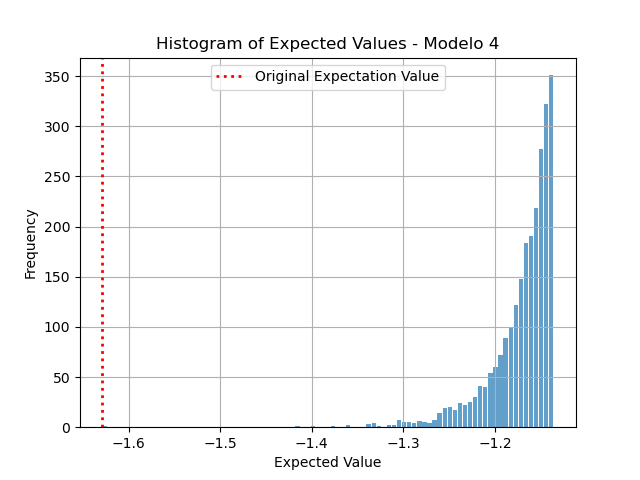

In [26]:
expected_values = df_temp['expectation_value_exact']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of Expected Values - Modelo {modelo}')
plt.legend()
plt.grid(True)

plt.show()

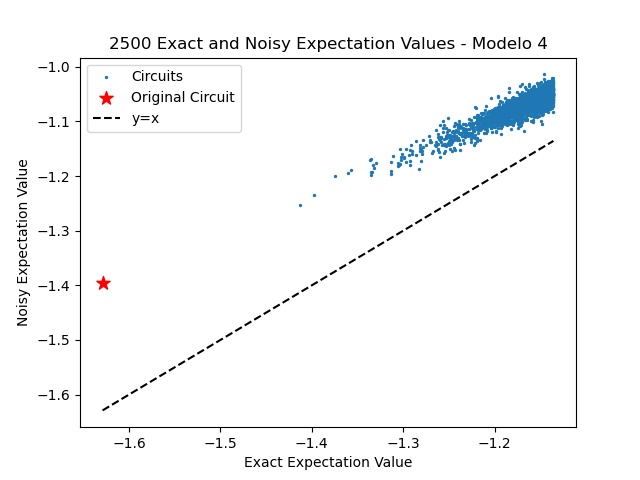

In [27]:
plt.figure()
plt.scatter(df_temp['expectation_value_exact'][1:], df_temp['expectation_value_noisy'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_exact'], df_temp.loc[0, 'expectation_value_noisy'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot([min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], [min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], 'k--', label='y=x')
plt.xlabel('Exact Expectation Value')
plt.ylabel('Noisy Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

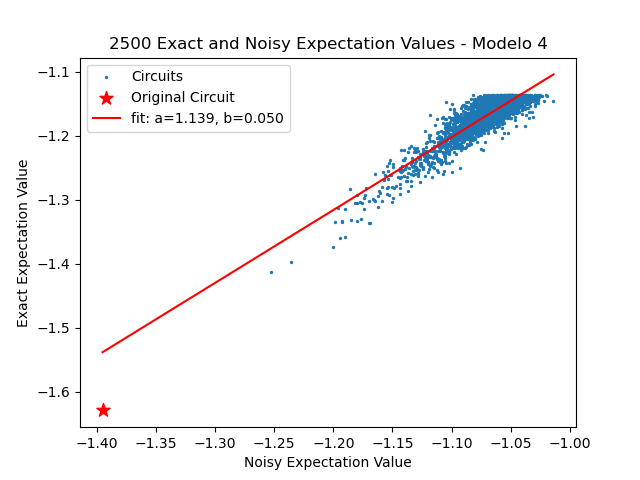

In [28]:
popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:])

plt.figure()
plt.scatter(df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_noisy'], df_temp.loc[0, 'expectation_value_exact'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot((x := np.linspace(min(df_temp['expectation_value_noisy']), max(df_temp['expectation_value_noisy']), 100)), func(x, *popt), "r", label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Noisy Expectation Value')
plt.ylabel('Exact Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

In [29]:
original = df_temp.loc[0, 'expectation_value_exact']
noisy = df_temp.loc[0, 'expectation_value_noisy']
corrected = func(noisy, *popt)
percentage = abs(abs(corrected - original) / original)* 100
percentage_noisy = abs(abs(corrected - noisy) / noisy)* 100

print(f"\nModelo {modelo} : \n\nOriginal Expectation Value: {original}\nNoisy Expectation Value: {noisy}\nCorrected Expectation Value: {corrected}\nPercentage Difference: {percentage}%\nPercentage Noisy Difference: {percentage_noisy}%")


Modelo 4 : 

Original Expectation Value: -1.6289938092430294
Noisy Expectation Value: -1.3950818279804187
Corrected Expectation Value: -1.5380691519507814
Percentage Difference: 5.5816453553313%
Percentage Noisy Difference: 10.249386172376527%
